### 50. データの入手・整形
News Aggregator Data Setをダウンロードし、以下の要領で学習データ（train.txt），検証データ（valid.txt），評価データ（test.txt）を作成せよ．

1. ダウンロードしたzipファイルを解凍し，readme.txtの説明を読む．
2. 情報源（publisher）が”Reuters”, “Huffington Post”, “Businessweek”, “Contactmusic.com”, “Daily Mail”の事例（記事）のみを抽出する．
3. 抽出された事例をランダムに並び替える．
4. 抽出された事例の80%を学習データ，残りの10%ずつを検証データと評価データに分割し，それぞれtrain.txt，valid.txt，test.txtというファイル名で保存する．ファイルには，１行に１事例を書き出すこととし，カテゴリ名と記事見出しのタブ区切り形式とせよ（このファイルは後に問題70で再利用する）．

学習データと評価データを作成したら，各カテゴリの事例数を確認せよ

In [1]:
import pandas as pd

In [2]:
# データの分割
from sklearn.model_selection import train_test_split

In [3]:
# データの読込
# readme.txtに書いてあったフォーマット:ID \t TITLE \t URL \t PUBLISHER \t CATEGORY \t STORY \t HOSTNAME \t TIMESTAMP
df = pd.read_csv('./newsCorpora_re.csv', header=None, sep='\t', names=['ID', 'TITLE', 'URL', 'PUBLISHER', 'CATEGORY', 'STORY', 'HOSTNAME', 'TIMESTAMP'])
# pd.read_csv:csvファイルを読み込む　(読み込むファイル名,ヘッダ行の有無,区切るとこ,名前)

In [4]:
# データの抽出
df = df.loc[df['PUBLISHER'].isin(['Reuters', 'Huffington Post', 'Businessweek', 'Contactmusic.com', 'Daily Mail']), ['TITLE', 'CATEGORY']]
# loc:特定の値を含むデータを抽出する

In [5]:
# データの分割
train, valid_test = train_test_split(df, test_size=0.2, shuffle=True, random_state=123, stratify=df['CATEGORY'])
# (入力データ, 入力データサンプルの割合（比率）を表す,シャッフル,中身を固定,分類の目的変数を指定し偏りが生じないようにする )
valid, test = train_test_split(valid_test, test_size=0.5, shuffle=True, random_state=123, stratify=valid_test['CATEGORY'])


In [6]:
# データの保存
# タブくぎり
train.to_csv('./train.txt', sep='\t', index=False)
valid.to_csv('./valid.txt', sep='\t', index=False)
test.to_csv('./test.txt', sep='\t', index=False)

In [7]:
# 事例数の確認
print('【学習データ】')
print(train['CATEGORY'].value_counts())
print('【検証データ】')
print(valid['CATEGORY'].value_counts())
print('【評価データ】')
print(test['CATEGORY'].value_counts())

【学習データ】
b    4501
e    4235
t    1220
m     728
Name: CATEGORY, dtype: int64
【検証データ】
b    563
e    529
t    153
m     91
Name: CATEGORY, dtype: int64
【評価データ】
b    563
e    530
t    152
m     91
Name: CATEGORY, dtype: int64


### 51. 特徴量抽出
学習データ，検証データ，評価データから特徴量を抽出し，それぞれtrain.feature.txt，valid.feature.txt，test.feature.txtというファイル名で保存せよ． なお，カテゴリ分類に有用そうな特徴量は各自で自由に設計せよ．記事の見出しを単語列に変換したものが最低限のベースラインとなるであろう．

In [8]:
# 特徴量はTF-IDFを用いる
# TF-IDE:各文書中に含まれる各単語が「その文書内でどれくらい重要か」を表す尺度

#テキストの前処理
import string #文字列操作
import re #正規表現操作

def preprocessing(text):
    table = str.maketrans(string.punctuation, ' '*len(string.punctuation))
    text = text.translate(table)  # 記号をスペースに置換
    text = text.lower()  # 小文字化
    text = re.sub('[0-9]+', '0', text)  # 数字列を0に置換
    return text

In [9]:
# データの再結合
df = pd.concat([train, valid, test], axis=0) # axis:縦横どちらで連結するか 0は縦
df.reset_index(drop=True, inplace=True)  # indexを振りなおす
# drop:元のindexを削除
# inplace:元のオブジェクトを変更

# 前処理の実施（見出し）
df['TITLE'] = df['TITLE'].map(lambda x: preprocessing(x))
# map(関数, シーケンス)

print(df.head())

                                               TITLE CATEGORY
0  refile update 0 european car sales up for sixt...        b
1  amazon plans to fight ftc over mobile app purc...        t
2  kids still get codeine in emergency rooms desp...        m
3  what on earth happened between solange and jay...        e
4  nato missile defense is flight tested over hawaii        b


In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer # TF-IDEのやつ

# データの分割
train_valid = df[:len(train) + len(valid)]
test = df[len(train) + len(valid):]

# TfidfVectorizer
vec_tfidf = TfidfVectorizer(min_df=10, ngram_range=(1, 2))  # ngram_rangeでTF-IDFを計算する単語の長さを指定

# ベクトル化
X_train_valid = vec_tfidf.fit_transform(train_valid['TITLE'])  # testの情報は使わない
X_test = vec_tfidf.transform(test['TITLE'])

# ベクトルをデータフレームに変換
X_train_valid = pd.DataFrame(X_train_valid.toarray(), columns=vec_tfidf.get_feature_names())
X_test = pd.DataFrame(X_test.toarray(), columns=vec_tfidf.get_feature_names())

# データの分割
X_train = X_train_valid[:len(train)]
X_valid = X_train_valid[len(train):]

# データの保存
X_train.to_csv('./X_train.txt', sep='\t', index=False)
X_valid.to_csv('./X_valid.txt', sep='\t', index=False)
X_test.to_csv('./X_test.txt', sep='\t', index=False)

print(X_train.head())


    0m  0million  0nd   0s  0st  0th  0th birthday   aa  aaliyah  abbvie  ...  \
0  0.0       0.0  0.0  0.0  0.0  0.0           0.0  0.0      0.0     0.0  ...   
1  0.0       0.0  0.0  0.0  0.0  0.0           0.0  0.0      0.0     0.0  ...   
2  0.0       0.0  0.0  0.0  0.0  0.0           0.0  0.0      0.0     0.0  ...   
3  0.0       0.0  0.0  0.0  0.0  0.0           0.0  0.0      0.0     0.0  ...   
4  0.0       0.0  0.0  0.0  0.0  0.0           0.0  0.0      0.0     0.0  ...   

   young  your  your mother   yr  yr high  yuan  zac  zac efron  zendaya  zone  
0    0.0   0.0          0.0  0.0      0.0   0.0  0.0        0.0      0.0   0.0  
1    0.0   0.0          0.0  0.0      0.0   0.0  0.0        0.0      0.0   0.0  
2    0.0   0.0          0.0  0.0      0.0   0.0  0.0        0.0      0.0   0.0  
3    0.0   0.0          0.0  0.0      0.0   0.0  0.0        0.0      0.0   0.0  
4    0.0   0.0          0.0  0.0      0.0   0.0  0.0        0.0      0.0   0.0  

[5 rows x 2815 columns]


### 52. 学習
51で構築した学習データを用いて，ロジスティック回帰モデルを学習せよ．

In [11]:
# ロジスティック回帰モデルのやつ
from sklearn.linear_model import LogisticRegression

# モデルの学習
lg = LogisticRegression(random_state=123, max_iter=10000)
lg.fit(X_train, train['CATEGORY']) # fitメソッド：ロジスティック回帰モデルの重みを学習

LogisticRegression(max_iter=10000, random_state=123)

### 53. 予測
52で学習したロジスティック回帰モデルを用い，与えられた記事見出しからカテゴリとその予測確率を計算するプログラムを実装せよ．

In [12]:
import numpy as np

def score_lg(lg, X):
    return [np.max(lg.predict_proba(X), axis=1), lg.predict(X)]

train_pred = score_lg(lg, X_train)
test_pred = score_lg(lg, X_test)

print(train_pred)

[array([0.8402797 , 0.67904346, 0.55638924, ..., 0.86051034, 0.6135933 ,
       0.90828244]), array(['b', 't', 'm', ..., 'b', 'm', 'e'], dtype=object)]


### 54. 正解率の計測
52で学習したロジスティック回帰モデルの正解率を，学習データおよび評価データ上で計測せよ．

In [13]:
from sklearn.metrics import accuracy_score

train_accuracy = accuracy_score(train['CATEGORY'], train_pred[1])
test_accuracy = accuracy_score(test['CATEGORY'], test_pred[1])
print(f'正解率（学習データ）：{train_accuracy:.3f}')
print(f'正解率（評価データ）：{test_accuracy:.3f}')

正解率（学習データ）：0.927
正解率（評価データ）：0.885


### 55. 混同行列の作
52で学習したロジスティック回帰モデルの混同行列（confusion matrix）を，学習データおよび評価データ上で作成せよ.

[[4344   93    8   56]
 [  52 4173    2    8]
 [  96  125  494   13]
 [ 192  133    7  888]]


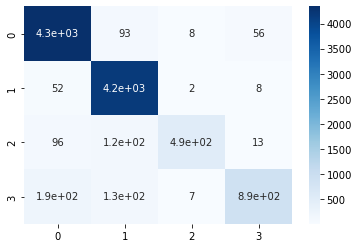

In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 学習データ
train_cm = confusion_matrix(train['CATEGORY'], train_pred[1])
print(train_cm)
sns.heatmap(train_cm, annot=True, cmap='Blues')
plt.show()

[[528  20   2  13]
 [ 12 516   1   1]
 [ 11  26  52   2]
 [ 38  26   1  87]]


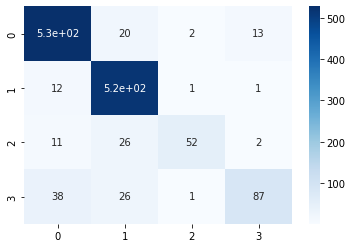

In [15]:
# 評価データ
test_cm = confusion_matrix(test['CATEGORY'], test_pred[1])
print(test_cm)
sns.heatmap(test_cm, annot=True, cmap='Blues')
plt.show()

### 56. 適合率，再現率，F1スコアの計測
52で学習したロジスティック回帰モデルの適合率，再現率，F1スコアを，評価データ上で計測せよ．カテゴリごとに適合率，再現率，F1スコアを求め，カテゴリごとの性能をマイクロ平均（micro-average）とマクロ平均（macro-average）で統合せよ．

In [16]:
from sklearn.metrics import precision_score, recall_score, f1_score

def calculate_scores(y_true, y_pred):
  # 適合率
    precision = precision_score(test['CATEGORY'], test_pred[1], average=None, labels=['b', 'e', 't', 'm'])  # Noneを指定するとクラスごとの精度をndarrayで返す
    precision = np.append(precision, precision_score(y_true, y_pred, average='micro'))  # 末尾にマイクロ平均を追加
    precision = np.append(precision, precision_score(y_true, y_pred, average='macro'))  # 末尾にマクロ平均を追加

    # 再現率
    recall = recall_score(test['CATEGORY'], test_pred[1], average=None, labels=['b', 'e', 't', 'm'])
    recall = np.append(recall, recall_score(y_true, y_pred, average='micro'))
    recall = np.append(recall, recall_score(y_true, y_pred, average='macro'))

    # F1スコア
    f1 = f1_score(test['CATEGORY'], test_pred[1], average=None, labels=['b', 'e', 't', 'm'])
    f1 = np.append(f1, f1_score(y_true, y_pred, average='micro'))
    f1 = np.append(f1, f1_score(y_true, y_pred, average='macro'))

    # 結果を結合してデータフレーム化
    scores = pd.DataFrame({'適合率': precision, '再現率': recall, 'F1スコア': f1},
                        index=['b', 'e', 't', 'm', 'マイクロ平均', 'マクロ平均'])

    return scores

In [17]:
print(calculate_scores(test['CATEGORY'], test_pred[1]))

             適合率       再現率     F1スコア
b       0.896435  0.937833  0.916667
e       0.877551  0.973585  0.923077
t       0.844660  0.572368  0.682353
m       0.928571  0.571429  0.707483
マイクロ平均  0.885479  0.885479  0.885479
マクロ平均   0.886804  0.763804  0.807395


### 57. 特徴量の重みの確認
52で学習したロジスティック回帰モデルの中で，重みの高い特徴量トップ10と，重みの低い特徴量トップ10を確認せよ

In [18]:
features = X_train.columns.values
index = [i for i in range(1, 11)]
for c, coef in zip(lg.classes_, lg.coef_):
    print(f'【カテゴリ】{c}')
    best10 = pd.DataFrame(features[np.argsort(coef)[::-1][:10]], columns=['重要度上位'], index=index).T
    worst10 = pd.DataFrame(features[np.argsort(coef)[:10]], columns=['重要度下位'], index=index).T
    display(pd.concat([best10, worst10], axis=0))
    print('\n')

【カテゴリ】b


,1,2,3,4,5,6,7,8,9,10
重要度上位,bank,fed,china,ecb,stocks,euro,obamacare,oil,yellen,dollar
重要度下位,video,ebola,the,her,and,she,apple,google,star,microsoft




【カテゴリ】e


,1,2,3,4,5,6,7,8,9,10
重要度上位,kardashian,chris,her,movie,star,film,paul,he,wedding,she
重要度下位,us,update,google,study,china,gm,ceo,facebook,apple,says




【カテゴリ】m


,1,2,3,4,5,6,7,8,9,10
重要度上位,ebola,study,cancer,drug,mers,fda,cases,cdc,could,cigarettes
重要度下位,facebook,gm,ceo,apple,bank,deal,google,sales,climate,twitter




【カテゴリ】t


,1,2,3,4,5,6,7,8,9,10
重要度上位,google,facebook,apple,microsoft,climate,gm,nasa,tesla,comcast,heartbleed
重要度下位,stocks,fed,her,percent,drug,american,cancer,ukraine,still,shares


### 58. 正則化パラメータの変更
ロジスティック回帰モデルを学習するとき，正則化パラメータを調整することで，学習時の過学習（overfitting）の度合いを制御できる．異なる正則化パラメータでロジスティック回帰モデルを学習し，学習データ，検証データ，および評価データ上の正解率を求めよ．実験の結果は，正則化パラメータを横軸，正解率を縦軸としたグラフにまとめよ．

In [19]:
from tqdm import tqdm

result = []
for C in tqdm(np.logspace(-5, 4, 10, base=10)):
    # モデルの学習
    lg = LogisticRegression(random_state=123, max_iter=10000, C=C)
    lg.fit(X_train, train['CATEGORY'])

    # 予測値の取得
    train_pred = score_lg(lg, X_train)
    valid_pred = score_lg(lg, X_valid)
    test_pred = score_lg(lg, X_test)

    # 正解率の算出
    train_accuracy = accuracy_score(train['CATEGORY'], train_pred[1])
    valid_accuracy = accuracy_score(valid['CATEGORY'], valid_pred[1])
    test_accuracy = accuracy_score(test['CATEGORY'], test_pred[1])

    # 結果の格納
    result.append([C, train_accuracy, valid_accuracy, test_accuracy])

100%|███████████████████████████████████████████| 10/10 [01:27<00:00,  8.77s/it]


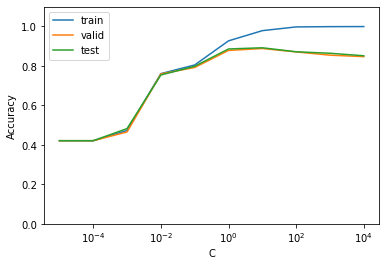

In [20]:
# 視覚化
result = np.array(result).T
plt.plot(result[0], result[1], label='train')
plt.plot(result[0], result[2], label='valid')
plt.plot(result[0], result[3], label='test')
plt.ylim(0, 1.1)
plt.ylabel('Accuracy')
plt.xscale ('log')
plt.xlabel('C')
plt.legend()
plt.show()

### 59. ハイパーパラメータの探索
学習アルゴリズムや学習パラメータを変えながら，カテゴリ分類モデルを学習せよ．検証データ上の正解率が最も高くなる学習アルゴリズム・パラメータを求めよ．また，その学習アルゴリズム・パラメータを用いたときの評価データ上の正解率を求めよ．